In [1]:
import pandas as pd
import stanza

/Users/asuka/Documents/projects/zarathustra_symp/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = open("../data/zar-final.txt", "r")
zarathustra = f.read()
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

2023-12-14 00:33:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-12-14 00:33:17 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2023-12-14 00:33:17 INFO: Using device: cpu
2023-12-14 00:33:17 INFO: Loading: tokenize
2023-12-14 00:33:18 INFO: Loading: mwt
2023-12-14 00:33:18 INFO: Loading: pos
2023-12-14 00:33:18 INFO: Loading: lemma
2023-12-14 00:33:18 INFO: Done loading processors!


In [ ]:
%%time
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

lemata = []
doc = nlp(zarathustra)
for sent in doc.sentences[:100]:
    for word in sent.words:
        lemata.append(word.to_dict())

lemata

In [ ]:
magorina = pd.DataFrame(lemata)
magorina.to_json('../outputs/zar-lemm.json')

In [3]:
def batch_process(text, nlp, batch_size=50):
    paragraphs = text.split('\n\n')
    batches = [paragraphs[i:i + batch_size] for i in range(0, len(paragraphs), batch_size)]

    all_lemmas = []

    for batch in batches:
        batch_text = '\n\n'.join(batch)
        doc = nlp(batch_text)
        for sentence in doc.sentences:
            for word in sentence.words:
                if word.lemma is not None:
                    all_lemmas.append(word.to_dict())

    return all_lemmas

In [4]:
%%time
lemmas=batch_process(zarathustra, nlp)
lemmas_df = pd.DataFrame(lemmas)
lemmas_df.to_json('../outputs/zarathustra-lemmas.json')

CPU times: user 2min 56s, sys: 39.1 s, total: 3min 35s
Wall time: 2min 16s


In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopset = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/asuka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [17]:
bcf = BigramCollocationFinder.from_words(entry['text'] for entry in lemmas)
filter_stops = lambda w: len(w) < 3 or w in stopset
bcf.apply_word_filter(filter_stops)
bcf.nbest(BigramAssocMeasures.likelihood_ratio, 30)

[('Thus', 'spoke'),
 ('superior', 'humans'),
 ('human', 'beings'),
 ('spoke', 'Zarathustra'),
 ('play', 'actors'),
 ('ugliest', 'man'),
 ('voluntary', 'beggar'),
 ('Great', 'Midday'),
 ('one', 'day'),
 ('And', 'verily'),
 ('holy', 'man'),
 ('said', 'Zarathustra'),
 ('Thou', 'shalt'),
 ('weight', 'bearing'),
 ('highest', 'hope'),
 ('famous', 'wise'),
 ('Never', 'yet'),
 ('fire', 'hound'),
 ('old', 'sorcerer'),
 ('nuptial', 'ring'),
 ('drifting', 'clouds'),
 ('wise', 'man'),
 ('brayed', 'Yea'),
 ('Deep', 'Midnight'),
 ('one', 'thing'),
 ('old', 'man'),
 ('Yonder', 'leads'),
 ('When', 'Zarathustra'),
 ('seven', 'days'),
 ('superior', 'human')]

In [26]:
word_counts = lemmas_df['lemma'].value_counts()
lemmas_df['occurences'] = lemmas_df['lemma'].map(word_counts)

In [38]:
#sanity check
count = 0

for entry in lemmas:
    if entry['lemma'] == 'Zarathustra':
        count += 1
    else:
        pass

print(count)

596


In [19]:
import matplotlib.pyplot as plt

In [58]:
def plot_word_dispersion(text, words):
    word_positions = {word: [] for word in words}

    for index, word in enumerate(text):
        if word in word_positions:
            word_positions[word].append(index)

    plt.figure(figsize=(15, 9))
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
    for i, (word, positions) in enumerate(word_positions.items()):
        plt.plot(positions, [i] * len(positions), 'o', label=word, color=colors[i % len(colors)])

    plt.yticks(range(len(words)), words)
    plt.ylim(-1, len(words))
    plt.title("Rozložení slov v textu")
    plt.xlabel("Pozice v textu")
    plt.ylabel("Slova")

    #plt.legend()
    plt.show()

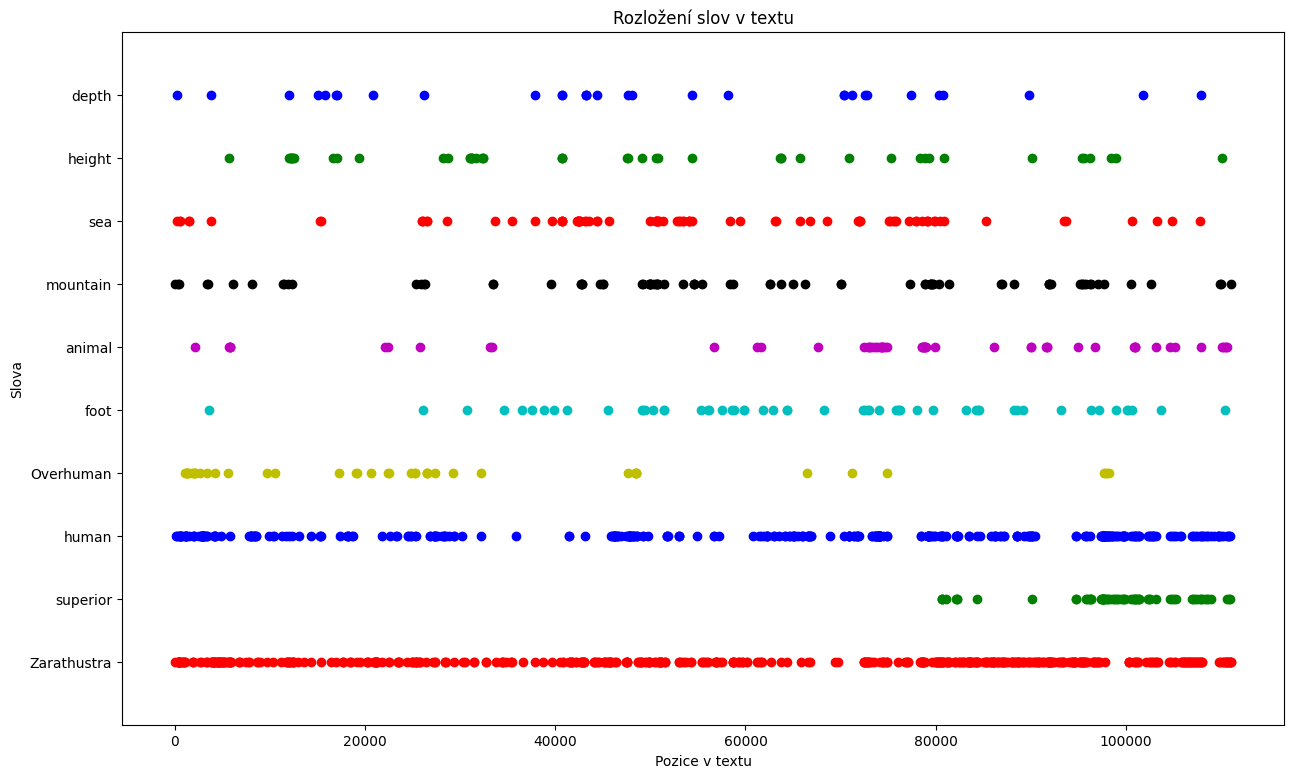

In [59]:
plot_word_dispersion(text = (entry['lemma'] for entry in lemmas), words=['Zarathustra', 'superior', 'human', 'Overhuman', 'foot', 'animal', 'mountain', 'sea', 'height', 'depth'])

In [61]:
from wordcloud import WordCloud

In [62]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopset,
                min_font_size = 10).generate(" ".join(lemmas_df['lemma']))

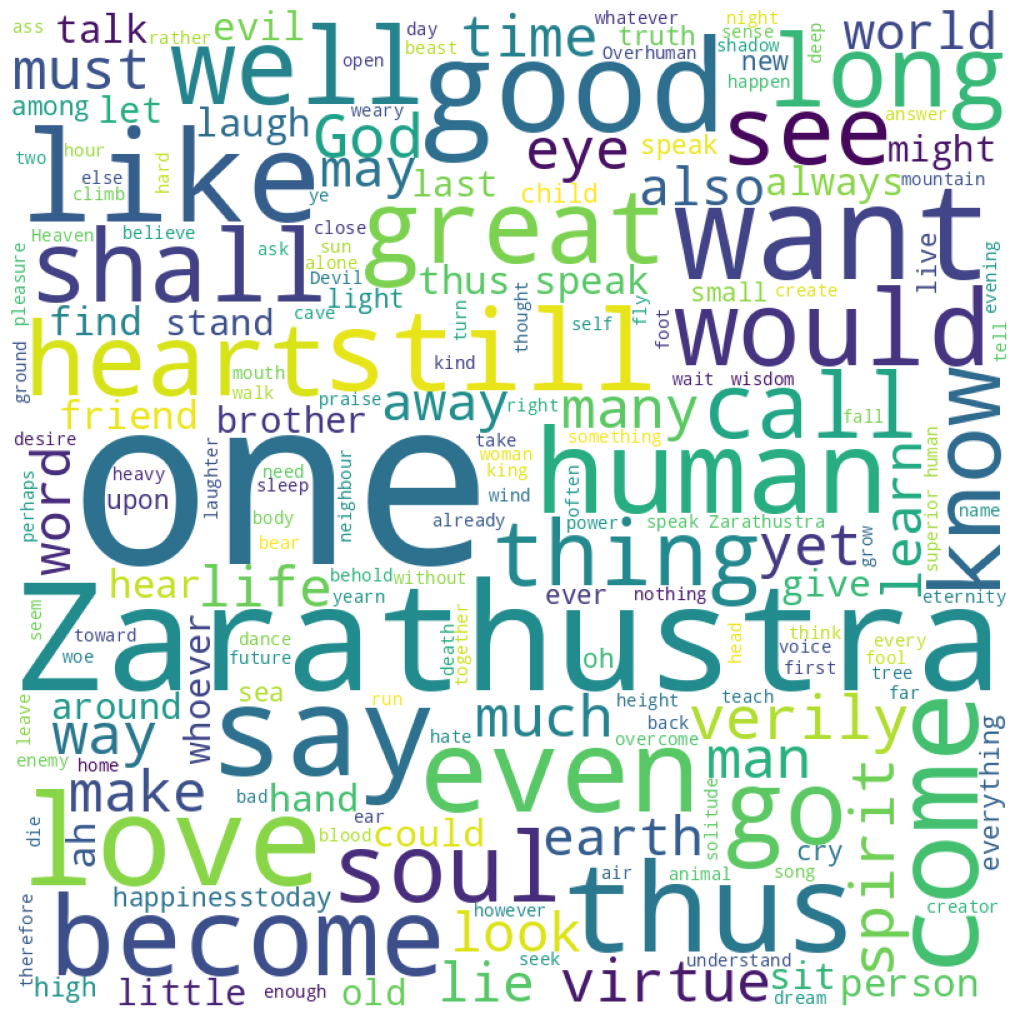

In [63]:
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()